In [1]:
import pandas as pd

data_in = pd.read_csv('../../counts_xy_true_vs_yolo_series.csv')
data_in

,frame_index,true_count,yolo_predicted_count,accuracy_pct
0,30,4,3,0.750000
1,46,5,4,0.800000
2,50,6,4,0.666667
3,58,8,5,0.625000
4,70,10,8,0.800000
...,...,...,...,...
88,7140,1535,1388,0.904235
89,7346,1575,1420,0.901587
90,7466,1598,1445,0.904255
91,7502,1602,1448,0.903870


[]

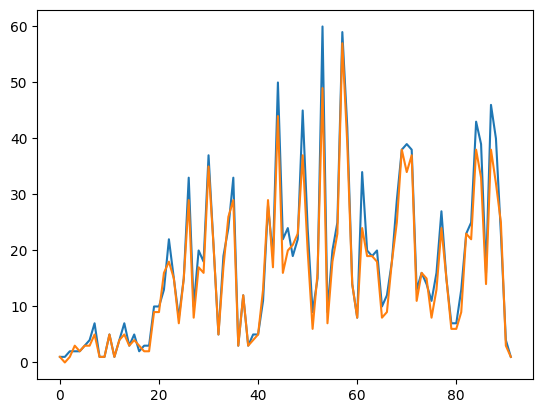

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = data_in.values
#print(data[:5])

m = data.shape[0]

data_d = np.empty((m-1,3), dtype=np.float32)



#column 0 is number of delta of frames
#column 1 and 2 are true and predicted
#		number of chicks since last observation

for i in range(1, m):
	data_d[i-1] = data[i, [0,1,2]] - data[i-1, [0,1,2]]

#for this to be determined as a linear issue
#we should be able to randomly segment this data at any point with some test split
#collection some coefficient
#and it should land about exactly the same for all splits around zero error

d_true = data_d[:, 1]
d_pred = data_d[:, 2]

#print(rate_tp[:5])

plt.plot(d_true)
plt.plot(d_pred)
plt.plot()
#rate_true

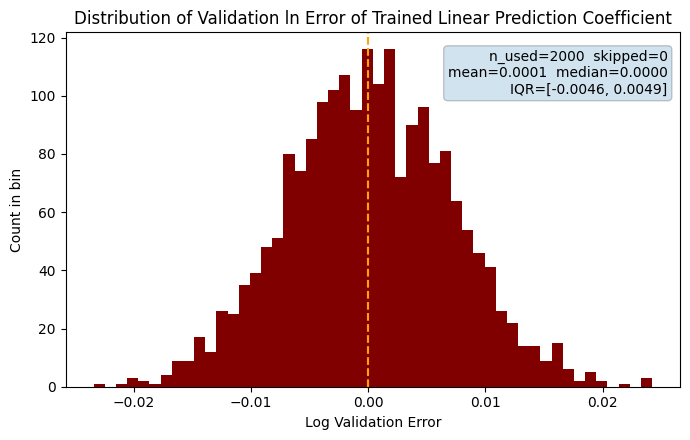

1.4005443760559446e-05 (np.float64(-0.004592034998747202), np.float64(0.004940514696240006))


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def mc_log_ratio_counting(
    d_true: np.ndarray,
    d_pred: np.ndarray,
    train_percent: float = 0.7,
    n_iters: int = 2000,
    rng: np.random.Generator | None = None,
    eps: float = 1e-12,           # numerical guard for zeros
    skip_zero_sums: bool = False, # if True, skip splits where sums <= 0 instead of adding eps
    plot: bool = True,
):
    """
    Monte Carlo random-split test for counting data using log error:
      log_err = ln( p_va / (t_va * r) ), with r = sum(p_tr)/sum(t_tr).

    Returns a dict with the per-split log errors and summary stats, and
    (optionally) shows a histogram.
    """
    d_true = np.asarray(d_true)
    d_pred = np.asarray(d_pred)
    assert d_true.shape == d_pred.shape and d_true.ndim == 1, "Inputs must be 1D and same shape."

    m = d_true.size
    assert 0 < train_percent < 1 and m >= 2, "Need 0<train_percent<1 and at least 2 samples."

    k = max(1, int(round(train_percent * m)))
    k = min(k, m - 1)  # keep both sets non-empty

    if rng is None:
        rng = np.random.default_rng()

    log_errs = []
    skipped = 0

    for _ in range(n_iters):
        idx = rng.permutation(m)
        tr, va = idx[:k], idx[k:]

        t_tr = d_true[tr].sum()
        p_tr = d_pred[tr].sum()
        t_va = d_true[va].sum()
        p_va = d_pred[va].sum()

        if skip_zero_sums:
            # Strict handling: require positive sums to define r and log
            if t_tr <= 0 or t_va <= 0 or p_va <= 0:
                skipped += 1
                continue
            r = p_tr / t_tr
            if r <= 0:
                skipped += 1
                continue
            log_err = np.log(p_va / (t_va * r))
        else:
            # Epsilon-stabilized handling (default)
            tt = t_tr if t_tr > 0 else eps
            r = (p_tr + eps) / (tt + eps)
            log_err = np.log((p_va + eps) / ((t_va + eps) * max(r, eps)))

        log_errs.append(log_err)

    log_errs = np.asarray(log_errs, dtype=float)
    mean_ = float(np.mean(log_errs)) if log_errs.size else np.nan
    med_  = float(np.median(log_errs)) if log_errs.size else np.nan
    p25, p75 = (np.percentile(log_errs, [25, 75]) if log_errs.size else (np.nan, np.nan))

    if plot and log_errs.size:
        plt.figure(figsize=(7, 4.5))
        plt.hist(log_errs, bins=50, color='maroon')
        plt.axvline(0.0, linestyle="--", c='orange')#dont tell anyone this is not gold these are maroon colors but you cant see gold crying emoji
        plt.title("Distribution of Validation ln Error of Trained Linear Prediction Coefficient")
        plt.xlabel("Log Validation Error")
        plt.ylabel("Count in bin")
        txt = (f"n_used={log_errs.size}  skipped={skipped}\n"
               f"mean={mean_:.4f}  median={med_:.4f}\n"
               f"IQR=[{p25:.4f}, {p75:.4f}]")
        plt.gca().text(0.98, 0.95, txt, transform=plt.gca().transAxes,
                       ha="right", va="top", bbox=dict(boxstyle="round", alpha=0.2))
        plt.tight_layout()
        plt.show()

    return {
        "log_errs": log_errs,     # per-split ln(p_va / (t_va * r))
        "mean": mean_,
        "median": med_,
        "iqr": (p25, p75),
        "n_used": int(log_errs.size),
        "n_skipped": int(skipped),
    }

# --- Example (uncomment to try) ---
rng = np.random.default_rng(7)
m = 800
d_true = rng.poisson(5.0, size=m)
bias = 1.12
noise = rng.normal(0, 0.5, size=m)
d_pred = np.clip(bias * d_true + noise, 0, None)
out = mc_log_ratio_counting(d_true, d_pred, train_percent=0.3, n_iters=2000, rng=rng)
print(out["median"], out["iqr"])


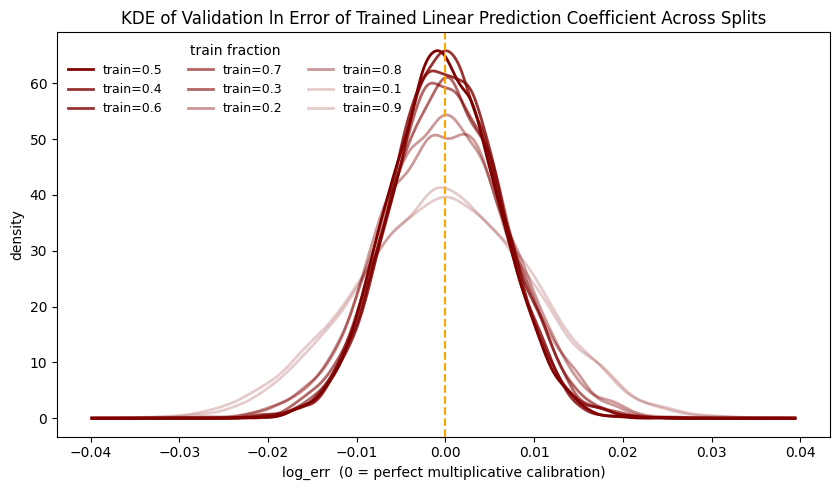

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- assumes mc_log_ratio_counting is already defined in your session ---

def _silverman_bandwidth(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    n = x.size
    if n < 2:
        return 1.0
    sd = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = min(sd, iqr / 1.34) if (sd > 0 and iqr > 0) else max(sd, iqr / 1.34, 1e-6)
    h = 0.9 * sigma * n ** (-1/5)
    return max(h, 1e-6)

def _kde_1d(x: np.ndarray, grid: np.ndarray, bw: float | None = None) -> np.ndarray:
    # Gaussian KDE: (1/(n*h*sqrt(2π))) * sum exp(-0.5*((grid - xi)/h)^2)
    x = np.asarray(x, dtype=float)
    grid = np.asarray(grid, dtype=float)
    n = x.size
    if n == 0:
        return np.zeros_like(grid)
    h = _silverman_bandwidth(x) if bw is None else max(float(bw), 1e-12)
    u = (grid[:, None] - x[None, :]) / h
    dens = np.exp(-0.5 * u * u).sum(axis=1) / (n * h * np.sqrt(2 * np.pi))
    return dens

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

# assumes: mc_log_ratio_counting, _silverman_bandwidth, _kde_1d already defined

def sweep_train_kdes(
    d_true: np.ndarray,
    d_pred: np.ndarray,
    train_percents: list[float] | np.ndarray = None,
    n_iters: int = 1000,
    rng: np.random.Generator | None = None,
    grid_points: int = 512,
    x_pad_std: float = 3.0,
    eps: float = 1e-12,
    skip_zero_sums: bool = False,
    show: bool = True,
):
    """
    Runs mc_log_ratio_counting over a set of train_percent values and plots KDEs.
    Colors: maroon with alpha that fades linearly with |train_percent - 0.5|.
    At 0.5 -> alpha = 1.0; at 0.1/0.9 -> alpha = 0.5.
    """
    if train_percents is None:
        train_percents = [i / 10 for i in range(1, 10)]  # 0.1..0.9

    if rng is None:
        rng = np.random.default_rng()

    # 1) Collect log_errs per train_percent
    all_logs = []
    results = {}
    for tp in train_percents:
        out = mc_log_ratio_counting(
            d_true,
            d_pred,
            train_percent=tp,
            n_iters=n_iters,
            rng=rng,
            eps=eps,
            skip_zero_sums=skip_zero_sums,
            plot=False,
        )
        le = out["log_errs"]
        results[tp] = {
            "log_errs": le,
            "mean": out["mean"],
            "median": out["median"],
            "iqr": out["iqr"],
            "n": out["n_used"],
            "skipped": out["n_skipped"],
        }
        if le.size:
            all_logs.append(le)

    if len(all_logs) == 0:
        raise ValueError("No usable log_errs collected (all splits skipped?).")

    # 2) Common plotting grid
    pooled = np.concatenate(all_logs)
    mu = float(np.mean(pooled))
    sd = float(np.std(pooled, ddof=1)) if pooled.size > 1 else 1.0
    xmin = pooled.min()
    xmax = pooled.max()
    if sd > 0:
        xmin = min(xmin, mu - x_pad_std * sd)
        xmax = max(xmax, mu + x_pad_std * sd)
    if xmin == xmax:
        xmin -= 1.0
        xmax += 1.0
    grid = np.linspace(xmin, xmax, grid_points)

    # 3) KDEs
    kdes = {}
    for tp in train_percents:
        le = results[tp]["log_errs"]
        kdes[tp] = _kde_1d(le, grid) if le.size else np.zeros_like(grid)

    # 4) Plot with maroon + alpha gradient by distance from 0.5
    if show:
        base_rgb = to_rgb("#800000")  # maroon
        def alpha_from_tp(tp: float) -> float:
            # distance from 0.5 over max 0.4 (from 0.1..0.9), fade up to 0.5
            dist = abs(tp - 0.5)
            frac = min(dist / 0.4, 1.0)  # 0 at center, 1 at edges (0.1 or 0.9)
            return 1.0 - 0.8 * frac      # 1.0 -> 0.5

        plt.figure(figsize=(8.5, 5.0))
        # Plot lighter (faded) first, intense last so intense stays on top
        for tp in sorted(train_percents, key=lambda x: -alpha_from_tp(x)):
            rgba = (*base_rgb, alpha_from_tp(tp))
            plt.plot(grid, kdes[tp], label=f"train={tp:.1f}", color=rgba, linewidth=2)

        plt.axvline(0.0, linestyle="--", alpha=1, c='orange')
        plt.title("KDE of Validation ln Error of Trained Linear Prediction Coefficient Across Splits")
        plt.xlabel("log_err  (0 = perfect multiplicative calibration)")
        plt.ylabel("density")
        plt.legend(title="train fraction", ncols=3, fontsize=9, frameon=False)
        plt.tight_layout()
        plt.show()

    return {"grid": grid, "kdes": kdes, "stats": results}


# --- Example usage (uncomment to try) ---
rng = np.random.default_rng(3)
m = 1000
d_true = rng.poisson(5.0, size=m)
d_pred = np.clip(1.12 * d_true + rng.normal(0, 0.5, size=m), 0, None)
out = sweep_train_kdes(d_true, d_pred, n_iters=5000, rng=rng)
#out["stats"][0.7]  # summary for train_percent=0.7
